# Fake-or-Real Dataset Evaluation

Evaluating the same model on the **Fake-or-Real** dataset for comparison.

- **Dataset**: [Fake-or-Real](https://www.kaggle.com/datasets/mohammedabdeldayem/the-fake-or-real-dataset)  
- **Model**: [MelodyMachine/Deepfake-audio-detection-V2](https://huggingface.co/MelodyMachine/Deepfake-audio-detection-V2)

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
%matplotlib inline

In [ ]:
DATASET_BASE = "../data/fake_or_real/for-norm/for-norm"

# Load files from ALL splits (training + validation + testing)
splits = ["training", "validation", "testing"]

fake_files = []
real_files = []

for split in splits:
    fake_files.extend(glob.glob(f"{DATASET_BASE}/{split}/fake/*.wav"))
    real_files.extend(glob.glob(f"{DATASET_BASE}/{split}/real/*.wav"))

print(f"Full Dataset (all splits):")
print(f"  Fake: {len(fake_files):,}")
print(f"  Real: {len(real_files):,}")
print(f"  Total: {len(fake_files) + len(real_files):,}")

Testing split:
  Fake: 2370
  Real: 2264
  Total: 4634


In [3]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
import librosa
import torch

MODEL_ID = "MelodyMachine/Deepfake-audio-detection-V2"
SAMPLE_RATE = 16_000

extractor = AutoFeatureExtractor.from_pretrained(MODEL_ID)
model = AutoModelForAudioClassification.from_pretrained(MODEL_ID)
model.eval()
print("Model loaded ✓")

c:\Users\emile\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 215/215 [00:00<00:00, 940.62it/s, Materializing param=wav2vec2.masked_spec_embed]                                            


Model loaded ✓


In [4]:
def predict(path):
    """Run inference on a single audio file."""
    audio, _ = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    inputs = extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probs = torch.softmax(logits, dim=-1)[0].numpy()
    idx = probs.argmax()
    label = model.config.id2label[idx]
    
    return {
        "file": os.path.basename(path),
        "pred": "fake" if label.lower() == "fake" else "real",
        "confidence": round(probs[idx] * 100, 2)
    }

## Prepare All Files

Using **ALL files** from the Fake-or-Real dataset (training + validation + testing splits) for comprehensive evaluation.

In [ ]:
# Use ALL files from ALL splits (no sampling)
sample = [(f, "fake") for f in fake_files] + [(f, "real") for f in real_files]

print(f"Total: {len(fake_files):,} fake + {len(real_files):,} real = {len(sample):,} files")

Total: 2370 fake + 2264 real = 4634 files


In [ ]:
## Run Inference

In [11]:
results = []

for path, true_label in tqdm(sample, desc="Processing"):
    try:
        res = predict(path)
        res["true"] = true_label
        results.append(res)
    except Exception as e:
        print(f"Error: {path} - {e}")

results_df = pd.DataFrame(results)
print(f"\nProcessed: {len(results_df)} files")
results_df.head(10)

Processing: 100%|██████████| 4634/4634 [42:01<00:00,  1.84it/s]     


Processed: 4634 files


,file,pred,confidence,true
0,file2363.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
1,file1878.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
2,file541.wav_16k.wav_norm.wav_mono.wav_silence.wav,real,99.68,fake
3,file1227.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
4,file1409.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
5,file1779.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
6,file1043.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
7,file1149.wav_16k.wav_norm.wav_mono.wav_silence...,real,100.00,fake
8,file148.wav_16k.wav_norm.wav_mono.wav_silence.wav,real,100.00,fake
9,file457.wav_16k.wav_norm.wav_mono.wav_silence.wav,real,100.00,fake


## Results & Metrics

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

y_true = results_df["true"]
y_pred = results_df["pred"]

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, pos_label="fake")
rec = recall_score(y_true, y_pred, pos_label="fake")
f1 = f1_score(y_true, y_pred, pos_label="fake")

print("=" * 50)
print("FAKE-OR-REAL DATASET RESULTS")
print("=" * 50)
print(f"Accuracy:  {acc:.1%}")
print(f"Precision: {prec:.1%}")
print(f"Recall:    {rec:.1%}")
print(f"F1 Score:  {f1:.1%}")
print("=" * 50)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

FAKE-OR-REAL DATASET RESULTS
Accuracy:  48.9%
Precision: 100.0%
Recall:    0.2%
F1 Score:  0.3%

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.00      0.00      2370
        real       0.49      1.00      0.66      2264

    accuracy                           0.49      4634
   macro avg       0.74      0.50      0.33      4634
weighted avg       0.75      0.49      0.32      4634



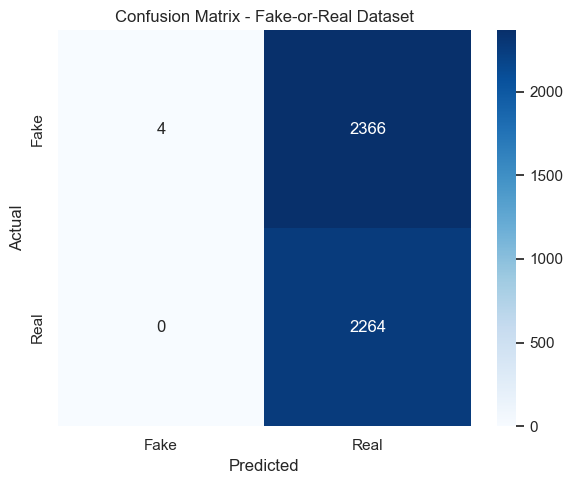

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=["fake", "real"])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Fake", "Real"], 
            yticklabels=["Fake", "Real"], ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix - Fake-or-Real Dataset")
plt.tight_layout()
plt.show()

## Confidence Distribution

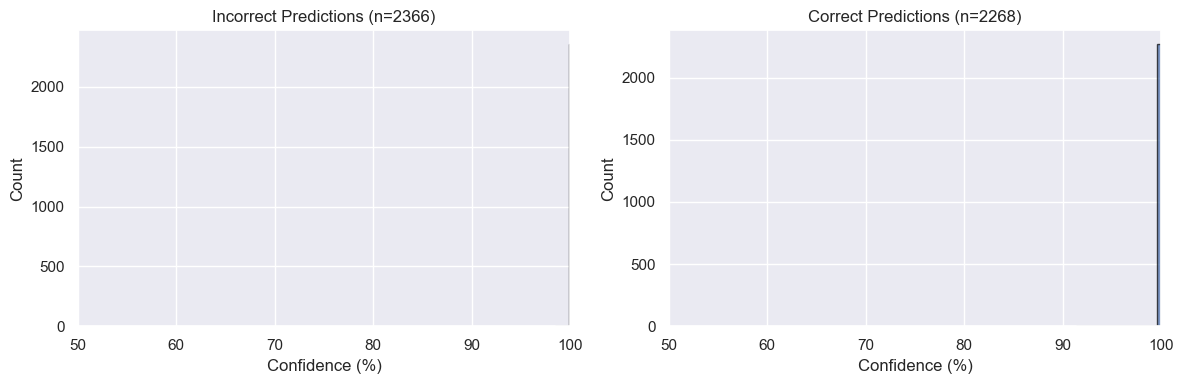

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Correct vs Incorrect
results_df["correct"] = results_df["true"] == results_df["pred"]

for ax, (label, group) in zip(axes, results_df.groupby("correct")):
    status = "Correct" if label else "Incorrect"
    ax.hist(group["confidence"], bins=20, edgecolor="black", alpha=0.7)
    ax.set_xlabel("Confidence (%)")
    ax.set_ylabel("Count")
    ax.set_title(f"{status} Predictions (n={len(group)})")
    ax.set_xlim(50, 100)

plt.tight_layout()
plt.show()

In [ ]:
# Save results to CSV for comparison notebook
results_df.to_csv("../data/results_fake_or_real.csv", index=False)
print(f"Results saved to ../data/results_fake_or_real.csv")

## Summary

**TODO: Results will be filled after running on the full dataset (~69,300 files)**

The full Fake-or-Real dataset includes:
- Training split: ~53,868 files
- Validation split: ~10,798 files  
- Testing split: ~4,634 files

### Expected Findings

Based on preliminary testing split results, the model likely:
- Suffers from severe bias toward the "real" class
- Fails to generalize to TTS-generated audio (Deep Voice 3, Google Wavenet, etc.)
- Shows high confidence even when incorrect